# 課題
## Car Fuel Consumption
https://www.kaggle.com/anderas/car-consume

## 目的（ゴール）

### DAY1
- 目的変数と説明変数の関係を確認するためのグラフを作成
- 目的変数を説明するのに有効そうな説明変数を見つける
- DAY1で学んだアルゴリズムを利用する
    - 回帰問題ー＞線形回帰
    - 質的変数が扱えないアルゴリズムを使う場合、ダミー変数に置き換え
- 予測精度または識別精度を確認する
    - 回帰問題ー＞MSE、RMSE、MAE


### DAY2、DAY3
- 前処理の改善
    - 前処理の改善と、欠測値と異常値を適切に処理する
        - DAY2
            - 正規化 / 標準化
            - 無相関化 / 白色化
        - DAY3
            - 特徴選択
        
- モデル
    - DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する
        - DAY2
            - 線形回帰の正則化(L1、L2、ElasticNet)
            - サポートベクターマシン(線形、非線形）
        - DAY3
            - 木モデル(決定木・ランダムフォレスト) 
            - ニューラルネットワーク

- 評価
    - 交差検証、ホールドアウト法などで汎化性能を確認する
    - 交差検証によるパラメータチューニングを行う
        - グリッドサーチを使って最適なパラメタを見つける
    - パラメータチューニング後のモデルによって、精度および結果の評価を行う
        - グリッドサーチで見つけたモデル・パラメタを使用し精度を測る

- まとめ
    - 前回から取り組んだ内容・工夫、精度がどのように変化したかをまとめる

## データセット

### 使用するデータセット
measurements.csv <br>

### 各項目の説明
| columns| 説明| 内容| 種類|
|:-----------|------------:|:------------:|:------------:|
| distance| 距離| km| 量的変数|
| consume| 消費量| L / 100km| 量的変数|
| speed| 平均速度| km/h| 量的変数|
| temp_inside| 内気温| ℃| 量的変数|
| temp_outside| 外気温|　℃| 量的変数|
| specials| スペシャル| 雨雪などの天気 <br>エアコンON/OFF| 質的変数|
| gas_type| ガソリンタイプ|　SP98、E10| 質的変数|
| AC| エアコン| 'ON':1、'OFF':0| 質的変数|
| rain| 雨| '雨':1、'雨じゃない':0| 質的変数|
| sun| 晴れ| '晴れ':1、'晴れじゃない':0| 質的変数|
| refill liters| リッター補充時の金額| ユーロ？| 量的変数|
| refill gas| ガソリン補充の種類| SP98、E10| 質的変数|

## ソースコード

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet

In [2]:
# データ読み取り
df_data = pd.read_csv('./data/measurements.csv')

In [3]:
# 取得したデータ確認
display(df_data.head())
display(df_data.describe())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


### データの整形

In [4]:
# 小数点表示を','から'.'に変更
df_data = df_data.replace('\,', '.', regex = True)

# 文字列から数値に変換
df_data['distance'] = df_data['distance'].astype(float)
df_data['consume'] = df_data['consume'].astype(float)
df_data['speed'] = df_data['speed'].astype(float)
df_data['temp_inside'] = df_data['temp_inside'].astype(float)
df_data['temp_outside'] = df_data['temp_outside'].astype(float)
df_data['refill liters'] = df_data['refill liters'].astype(float)

# 'SP98':0, 'E10':1に変換
df_data.loc[df_data['gas_type'] == 'SP98', 'gas_type'] = 0
df_data.loc[df_data['gas_type'] == 'E10', 'gas_type'] = 1
df_data.loc[df_data['refill gas'] == 'SP98', 'refill gas'] = 0
df_data.loc[df_data['refill gas'] == 'E10', 'refill gas'] = 1

In [5]:
# スペシャルの中身確認
df_data['specials'].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
sun ac                 3
snow                   3
AC snow                1
half rain half sun     1
ac rain                1
AC sun                 1
AC Sun                 1
Name: specials, dtype: int64

In [6]:
# '大文字小文字がバラバラなのでAC'と'sun'に統一
df_data.loc[df_data['specials'] == 'Sun', 'specials'] = 'sun'
df_data.loc[df_data['specials'] == 'ac', 'specials'] = 'AC'
df_data.loc[df_data['specials'] == 'AC Sun', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'sun ac', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'ac rain', 'specials'] = 'AC rain'
df_data['specials'].value_counts()

rain                  32
sun                   27
AC                    14
AC rain               10
AC sun                 5
snow                   3
AC snow                1
half rain half sun     1
Name: specials, dtype: int64

In [7]:
# 'specials’をダミー変数に置き換え
df_specials = pd.get_dummies(df_data['specials'])
df_specials.columns = [
    '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun', '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'
]
df_data = pd.concat([df_data, df_specials], axis=1)

# ダミー変数に置き換えたので'specials'は削除
df_data = df_data.drop(['specials'], axis=1)

# TODO AC,rain,sunとspecialのAC,rain,sunはまとめることができないか?

In [8]:
# 欠損値確認
df_data.isnull().sum()

distance                   0
consume                    0
speed                      0
temp_inside               12
temp_outside               0
gas_type                   0
AC                         0
rain                       0
sun                        0
refill liters            375
refill gas               375
[s]AC                      0
[s]AC rain                 0
[s]AC snow                 0
[s]AC sun                  0
[s]half rain half sun      0
[s]rain                    0
[s]snow                    0
[s]sun                     0
dtype: int64

In [9]:
#  temp_insideの欠損値は、平均値を入れる
# TODO 平均値で良いのか？
df_data['temp_inside'] = df_data['temp_inside'].fillna(
    df_data['temp_inside'].mean()
)

# 'refill liters','refil gas'は欠損値多すぎるので削除
# TODO 消さずに使う方法は無いか？
df_data = df_data.drop('refill liters', axis=1)
df_data = df_data.drop('refill gas', axis=1)

### グラフを可視化

In [10]:
# 散布図行列は表示項目が多すぎて見づらいため省略
# pd.plotting.scatter_matrix(df_data, figsize=(10,10))
# plt.show()

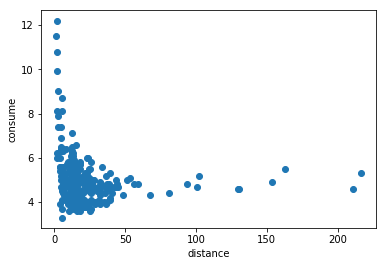

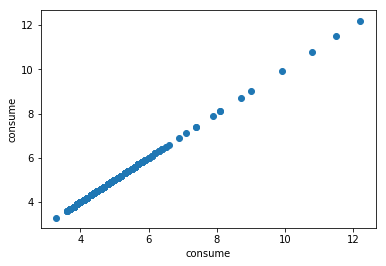

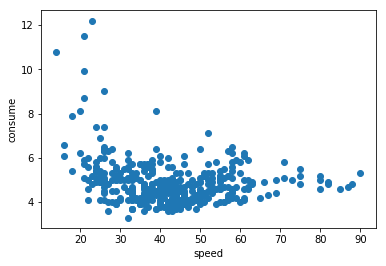

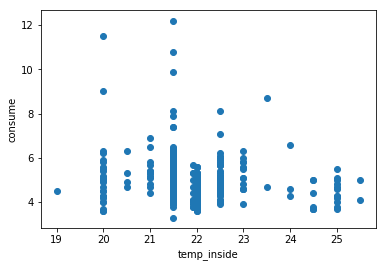

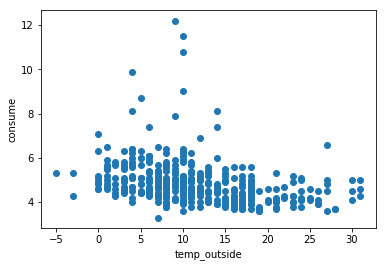

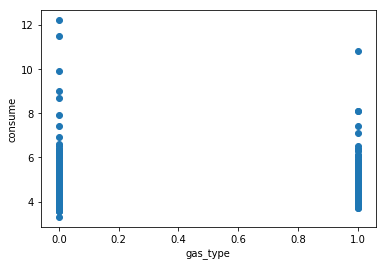

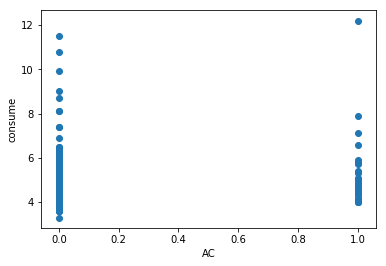

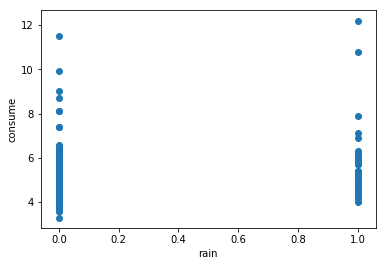

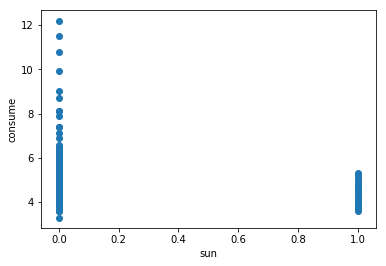

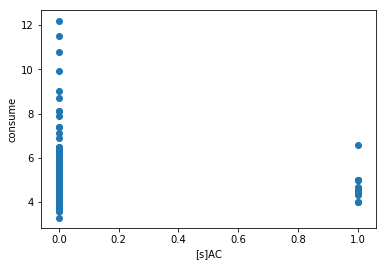

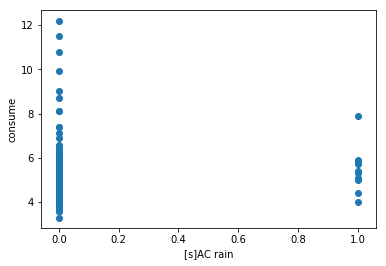

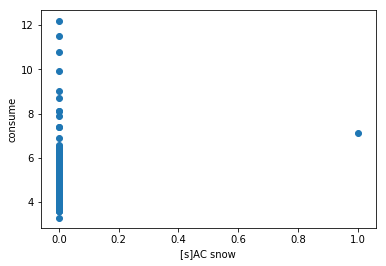

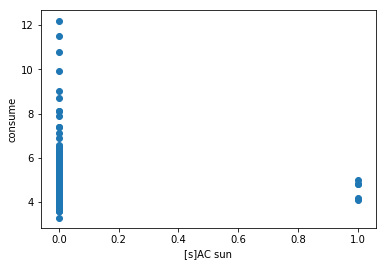

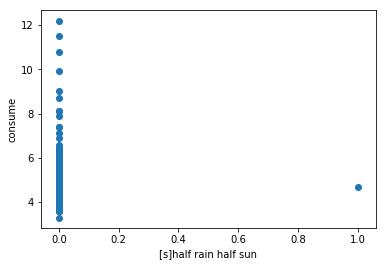

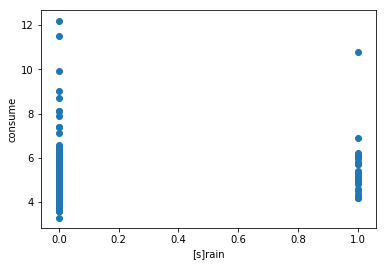

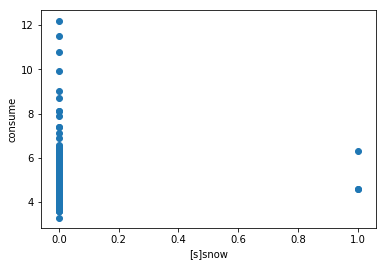

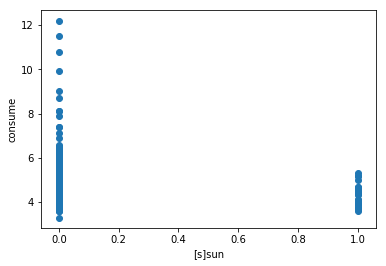

In [11]:
# consumeに絞って散布図表示してみる
for column in df_data.columns:
    plt.scatter(df_data[column], df_data['consume'])
    plt.xlabel(column)
    plt.ylabel('consume')
    plt.show()

,consume
consume,1.000000
temp_outside,0.320811
rain,0.248118
speed,0.227866
sun,0.170667
[s]sun,0.168194
temp_inside,0.160623
[s]rain,0.157122
distance,0.128967
[s]AC snow,0.107772


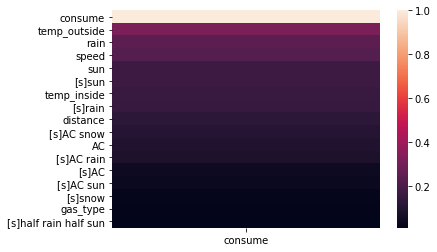

In [12]:
# 'consume'に絞って、相関係数、ヒートマップを可視化
consume_corr = df_data.corr()['consume']

# 相関係数の絶対値でソート
sorted_consume_corr = pd.DataFrame(abs(consume_corr).sort_values(ascending=False))

display(sorted_consume_corr)
sns.heatmap(sorted_consume_corr)

### 検証

- モデル：線形回帰
- 目的変数：consume

#### 説明変数の選択
consumeとの相関係数（の絶対値）が大きいデータを選択すれば一般的には問題なさそうだが、念の為、相関係数（の絶対値）が小さいデータから少しずつ値を絞っていき、最終的には相関係数（の絶対値）が大きいデータを説明変数とした場合の精度を計測してみた。

In [13]:
mse, mae, rmse = {}, {}, {}
def evaluate_normal_precision(X, y, exp_num):
    """訓練誤差のみ"""
    
    # 線形回帰
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X, y)

    # 　制度の確認
    y_pred = regr.predict(X)
    mse[exp_num] = mean_squared_error(y, y_pred)
    mae[exp_num] = mean_absolute_error(y, y_pred)
    rmse[exp_num] = np.sqrt(mse[exp_num])

    print("MSE = {}".format(round(mse[exp_num], 3)))
    print("MAE = {}".format(round(mae[exp_num], 3)))
    print("RMSE = {}".format(round(rmse[exp_num], 3)))

In [14]:
predict_mae, test_mae = {}, {}
def evaluate_hold_out(X, y, exp_num):
    """ホールドアウト法"""
    
    # 全データのうち、何%をテストデータにするか（今回は20%に設定）
    test_size = 0.2
    
    # ホールドアウト法を実行（テストデータはランダム選択）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # 学習用データに対する予測を実行
    y_pred_train = regr.predict(X_train)

    # 学習データに対するMAEを計算（訓練誤差の評価）
    predict_mae[exp_num] = mean_absolute_error(y_train, y_pred_train)
    
    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)

    # テストデータに対するMAEを計算（汎化誤差の評価）
    test_mae[exp_num] = mean_absolute_error(y_test, y_pred_test)

    print("predict MAE = {}".format(round(predict_mae[exp_num], 3)))
    print("test MAE = {}".format(round(test_mae[exp_num], 3)))

In [15]:
final_mae = {}
def evaluate_cross_varidation(X, y, exp_num):
    """クロスバリデーション法"""
    
    # グループ数を設定（今回は5分割）
    n_split = 5

    # テスト役を交代させながら学習と評価を繰り返す
    cross_valid_mae = 0
    split_num = 1
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # 学習用データを使って線形回帰モデルを学習
        regr = LinearRegression(fit_intercept=False)
        regr.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = regr.predict(X_test)

        # テストデータに対するMAEを計算
        mae_fold = mean_absolute_error(y_test, y_pred_test)
        print("Fold{} MAE = {}".format(split_num, round(mae_fold, 3)))

        # 後で平均を取るためにMAEを加算
        cross_valid_mae += mae_fold
        split_num += 1

    # MAEの平均値を最終的な汎化誤差値とする
    final_mae[exp_num] = cross_valid_mae / n_split
    print("Cross Validation MAE = {}".format(round(final_mae[exp_num], 3)))

In [21]:
final_grid_search_best_params = {}
final_grid_search_best_score = {}
final_grid_search_mae = {}
def evaluate_grid_search(X, y, exp_num, parameters, model):
    """グリッドサーチ法"""

    # TODO test_sizeは0.3固定でいいか？
    #  ここもクロスバリデーションを使うべきか？
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    est = GridSearchCV(model, parameters, cv=3)
    est.fit(X_train, y_train)

    final_grid_search_best_params[exp_num] = est.best_params_
    final_grid_search_best_score[exp_num] = est.best_score_
    
    print("best params = {}".format(final_grid_search_best_params[exp_num]))
    print("best score = {}".format(final_grid_search_best_score[exp_num]))

    # 最適パラメータを用いて識別する
    est2 = SVR(**est.best_params_)
    est2.fit(X_train, y_train)
    
#  今回は評価値はmaeで統一するためコメントアウト
#     final_grid_search_score[exp_num] = est2.score(X_test, y_test)
#     print("識別精度 = {}".format(final_grid_search_score[exp_num]))
    
    # テストデータに対する予測を実行
    y_pred_test = est2.predict(X_test)

    # テストデータに対するMAEを計算
    final_grid_search_mae[exp_num] = mean_absolute_error(y_test, y_pred_test)
    print("Grid Search MAE = {}".format(round(final_grid_search_mae[exp_num], 3)))

#### グリッドサーチなし

In [17]:
# 相関係数の値を変えながら、
# それを満たす説明変数で精度を計測
division_num = 0.01
for exp_num in np.arange(0, 1, division_num):
    #  説明変数設定
    exp_data = consume_corr[
        abs(consume_corr) >= exp_num
    ].index
    exp_data = exp_data.drop('consume')

    print('\n-----------------------------------')
    print("<|相関係数| >= {}".format(exp_num))

    if len(exp_data):
        print('\n<説明変数>')
        print(exp_data)
    else:
        print('\n該当する説明変数無し -> 終了！')
        break

    X = df_data[exp_data].values
    y = df_data['consume'].values

    print('\n<訓練誤差のみ>')
    evaluate_normal_precision(X, y, exp_num)

    print('\n<ホールドアウト法>')
    evaluate_hold_out(X, y, exp_num)

    print('\n<クロスバリデーション法>')
    evaluate_cross_varidation(X, y, exp_num)


-----------------------------------
<|相関係数| >= 0.0

<説明変数>
Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC',
       'rain', 'sun', '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun',
       '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'],
      dtype='object')

<訓練誤差のみ>
MSE = 0.737
MAE = 0.585
RMSE = 0.858

<ホールドアウト法>
predict MAE = 0.571
test MAE = 0.666

<クロスバリデーション法>
Fold1 MAE = 0.717
Fold2 MAE = 0.948
Fold3 MAE = 0.809
Fold4 MAE = 0.584
Fold5 MAE = 0.761
Cross Validation MAE = 0.764

-----------------------------------
<|相関係数| >= 0.01

<説明変数>
Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC',
       'rain', 'sun', '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun',
       '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'],
      dtype='object')

<訓練誤差のみ>
MSE = 0.737
MAE = 0.585
RMSE = 0.858

<ホールドアウト法>
predict MAE = 0.571
test MAE = 0.666

<クロスバリデーション法>
Fold1 MAE = 0.717
Fold2 MAE = 0.948
Fold3 MAE = 0.809
Fold4 MAE = 

Fold4 MAE = 1.457
Fold5 MAE = 4.312
Cross Validation MAE = 3.038

-----------------------------------
<|相関係数| >= 0.33

該当する説明変数無し -> 終了！


#### 最適解

In [18]:
min_mae = min(final_mae.values())
min_corr = [k for k, v in final_mae.items() if v == min_mae]
exp_data = consume_corr[abs(consume_corr) >= min_corr[0]].index

print('<線形回帰モデル and グリッドサーチなし>')
print("|相関係数| >= {}".format(min_corr))
print("説明変数　= {}".format(exp_data))
print("最小のCross Validation MAE = {}".format(round(min_mae, 3)))

<線形回帰モデル and グリッドサーチなし>
|相関係数| >= [0.16]
説明変数　= Index(['consume', 'speed', 'temp_inside', 'temp_outside', 'rain', 'sun',
       '[s]sun'],
      dtype='object')
最小のCross Validation MAE = 0.681


#### 結果をグラフ化

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


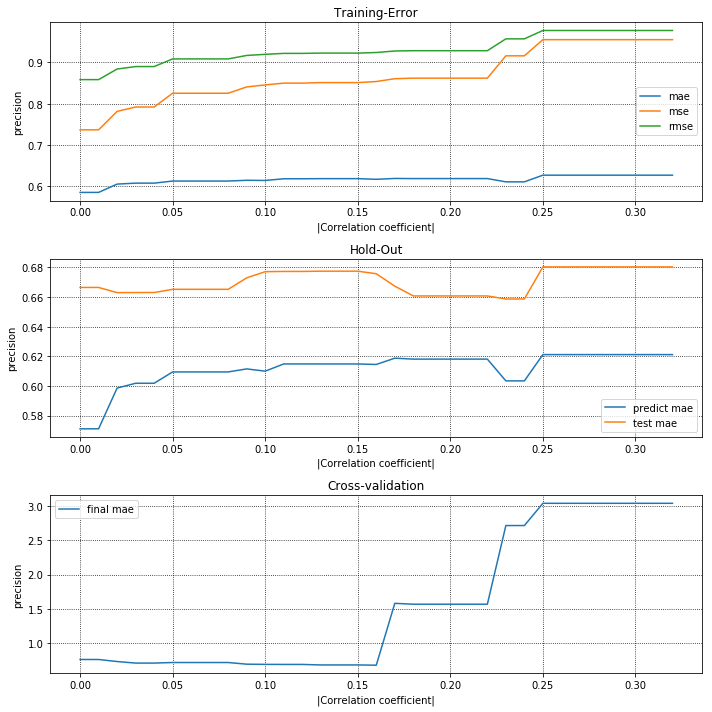

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# 訓練誤差のみ
ax[0].set_title('Training-Error')
ax[0].plot(mae.keys(), mae.values(), label='mae')
ax[0].plot(mse.keys(), mse.values(), label='mse')
ax[0].plot(rmse.keys(), rmse.values(), label='rmse')

# ホールドアウト法
ax[1].set_title('Hold-Out')
ax[1].plot(predict_mae.keys(), predict_mae.values(), label='predict mae')
ax[1].plot(test_mae.keys(), test_mae.values(), label='test mae')

# クロスバリデーション法
ax[2].set_title('Cross-validation')
ax[2].plot(final_mae.keys(), final_mae.values(), label='final mae')

for i in range(3):
    ax[i].set_xlabel('|Correlation coefficient|')
    ax[i].set_ylabel('precision')
    ax[i].grid(which='major',color='black',linestyle=':')
    ax[i].grid(which='minor',color='black',linestyle=':')
    ax[i].legend()

fig.tight_layout()
fig.show()

#### グリッドサーチあり

In [24]:
# 相関係数の値を変えながら、
# それを満たす説明変数で精度を計測
division_num = 0.1
for exp_num in np.arange(0, 1, division_num):
    #  説明変数設定
    exp_data = consume_corr[
        abs(consume_corr) >= exp_num
    ].index
    exp_data = exp_data.drop('consume')

    print('\n-----------------------------------')
    print("<|相関係数| >= {}".format(exp_num))

    if len(exp_data):
        print('\n<説明変数>')
        print(exp_data)
    else:
        print('\n該当する説明変数無し -> 終了！')
        break

    X = df_data[exp_data].values
    y = df_data['consume'].values

    print('\n<グリッドサーチ法>')
    print('<SVR>')
    parameters = {
        'kernel':['linear', 'rbf'], 
        'C':[1, 5, 10]
    }
    model = SVR()
    evaluate_grid_search(X, y, exp_num, parameters, model)

#     TODO パラメタ指定部分でエラー出てる
#     #  TODO 多項式はどうやる？
#     print('\n<線形回帰 正則化なし>')
#     parameters = {
#     }
#     model = LinearRegression()
#     evaluate_grid_search(X, y, exp_num, parameters, model)

#     print('\n<線形回帰 Ridge>')
#     parameters = {
#         'alpha':[0.0, 1e-8, 1e-5, 1e-1]
#     }
#     model = Ridge()
#     evaluate_grid_search(X, y, exp_num, parameters, model)
    
#     print('\n<線形回帰 Lasso>')
#     parameters = {
#         'alpha':[1e-20, 1e-3, 1e-2, 1e-1], 
#         'max_iter':[1e7]
#     }
#     model = Lasso()
#     evaluate_grid_search(X, y, exp_num, parameters, model)
    
#     print('\n<線形回帰 ElasticNet>')
#     parameters = {
#         'alpha':[1e-20, 1e-3, 1e-2, 1e-1], 
#         'l1_ratio':[0, 0.1, 0.5, 1.0],
#         'max_iter':[1e7]
#     }
#     model = ElasticNet()
#     evaluate_grid_search(X, y, exp_num, parameters, model)


-----------------------------------
<|相関係数| >= 0.0

<説明変数>
Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC',
       'rain', 'sun', '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun',
       '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'],
      dtype='object')

<グリッドサーチ法>
<SVR>
best params = {'C': 5, 'kernel': 'rbf'}
best score = 0.4065681843246086
Grid Search MAE = 0.564

-----------------------------------
<|相関係数| >= 0.1

<説明変数>
Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'rain', 'sun',
       '[s]AC snow', '[s]rain', '[s]sun'],
      dtype='object')

<グリッドサーチ法>
<SVR>
best params = {'C': 10, 'kernel': 'rbf'}
best score = 0.2984384380657413
Grid Search MAE = 0.593

-----------------------------------
<|相関係数| >= 0.2

<説明変数>
Index(['speed', 'temp_outside', 'rain'], dtype='object')

<グリッドサーチ法>
<SVR>
best params = {'C': 1, 'kernel': 'linear'}
best score = 0.16875481789555388
Grid Search MAE = 0.583

-----------------------------------
<|相関

#### 最適解

In [29]:
# TODO グリッドサーチすると最適な相関係数が違う？
min_grid_search_mae = min(final_grid_search_mae.values())
min_corr = [k for k, v in final_grid_search_mae.items() if v == min_grid_search_mae]
exp_data = consume_corr[abs(consume_corr) >= min_corr[0]].index
max_grid_search_score = final_grid_search_best_score[min_corr[0]]

print('\n<いろんなモデル and グリッドサーチあり>')
print("|相関係数| >= {}".format(min_corr))
print("説明変数　= {}".format(exp_data))
print("最小のGird Search MAE = {}".format(round(min_grid_search_mae, 3)))
print("Grid Search best param = {}".format(final_grid_search_best_params[min_corr[0]]))
print("Grid Search best score = {}".format(max_grid_search_score))


<いろんなモデル and グリッドサーチあり>
|相関係数| >= [0.0, 0.01]
説明変数　= Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'gas_type', 'AC', 'rain', 'sun', '[s]AC', '[s]AC rain', '[s]AC snow',
       '[s]AC sun', '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'],
      dtype='object')
最小のGird Search MAE = 0.564
Grid Search best param = {'C': 5, 'kernel': 'rbf'}
Grid Search best score = 0.4065681843246086


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


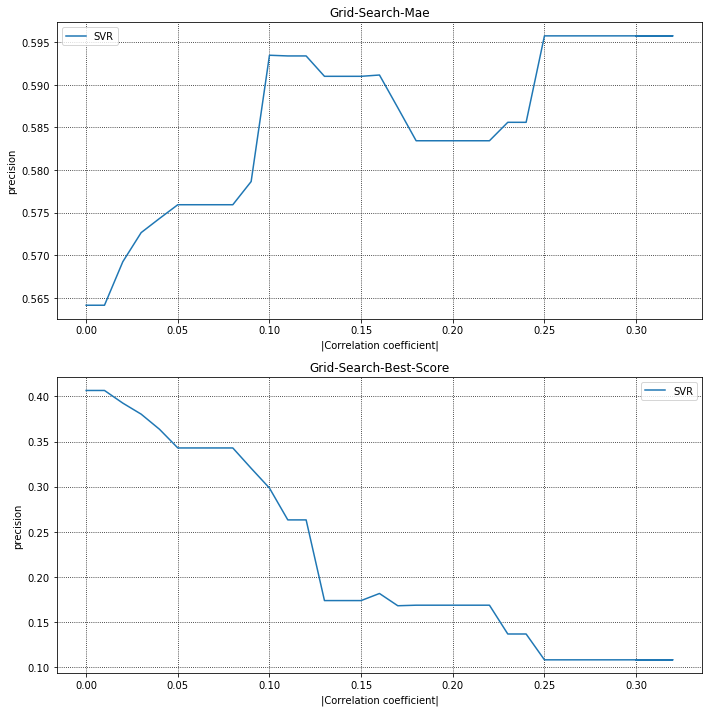

In [40]:
# 結果をグラフ表示
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].set_title('Grid-Search-Mae')
ax[0].plot(final_grid_search_mae.keys(), final_grid_search_mae.values(), label='SVR')

ax[1].set_title('Grid-Search-Best-Score')
ax[1].plot(final_grid_search_best_score.keys(), final_grid_search_best_score.values(), label='SVR')

for i in range(2):
    ax[i].set_xlabel('|Correlation coefficient|')
    ax[i].set_ylabel('precision')
    ax[i].grid(which='major',color='black',linestyle=':')
    ax[i].grid(which='minor',color='black',linestyle=':')
    ax[i].legend()

fig.tight_layout()
fig.show()

## まとめ
### 検証結果
TODO

### 前回から取り組んだ内容・工夫、精度がどのように変化したか
- 重みと二乗誤差の確認は削除（使わないから）
- 線形回帰、正則化なしで、ホールドアウト法、クロスバリデーション法を試したところ、|相関係数|が0.16の時にクロスバリデーションのMAEが最小となった。
- SVRを試したところ、|相関係数| が0, 0.1の時に最適となった。
- TODO